# Clustering

Using clustering, we may be able to find particular clusters of patients that have a higher amount of Alzheimer's disease than others. Then, based on the differences between clusters, we might be able to find a pattern.

In [1]:
import data_reader
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.decomposition import PCA


def dissimilarity_score(v1, v2):
    # For categorical variables, calculating the euclidian distance is not
    # correct. Therefore, the amount of differences should just be counted.
    return np.sum(v1 != v2)


def euclidian_distance(v1, v2):
    return np.sqrt(np.sum((v1 - v2)**2))


def assign_cluster(prototypes, clusters, point):
    dissimilarities = []
    for pt in prototypes:
        v_n = num_matrix[point]
        v_c = cat_matrix[point]
        pt_v_n = pt[0]
        pt_v_c = pt[1]
        dissimilarity = dissimilarity_score(
            pt_v_n, v_n) + euclidian_distance(pt_v_c, v_c)
        dissimilarities.append(dissimilarity)

    dissimilarities = np.array(dissimilarities)
    cluster = np.where(dissimilarities == dissimilarities.min())[0][0]
    clusters[cluster].append((num_matrix[point], cat_matrix[point]))

    return clusters


def calc_prototype(cluster, init_index):
    if len(cluster) == 0:
        # Whenever a cluster is empty, reset the prototype to what the prototype
        # originally was for this cluster. Taking the means/modes of all variables
        # or setting it to 0 did not work well, as it would result in lots of
        # empty clusters.
        return (num_matrix[init_index], cat_matrix[init_index])
    num_cluster = np.vstack([point[0] for point in cluster])
    num_prototype = np.mean(num_cluster, axis=0)
    cat_cluster = np.vstack([point[1] for point in cluster])
    cat_prototype = mode(cat_cluster, axis=0).mode

    return (num_prototype, cat_prototype)


def k_prototypes_clustering(num_matrix, cat_matrix, k, verbose=False, initial_prototypes=None):
    if initial_prototypes is None:
        # Randomly select k initial prototype indexes
        prototypes_indices = np.random.randint(0, len(num_matrix), k)
        init_indexes = prototypes_indices.copy()
        if verbose:
            print(f'Selected initial prototypes indices: {prototypes_indices}')

        # Initialize prototypes as a list of tuples with numeric and categorical data
        prototypes = [(num_matrix[i], cat_matrix[i])
                      for i in prototypes_indices]
    else:
        init_indexes = initial_prototypes.copy()
        if len(initial_prototypes) != k:
            raise ValueError("The number of initial prototypes must match k.")
        prototypes = [(num_matrix[i], cat_matrix[i])
                      for i in initial_prototypes]

    clusters = [[] for _ in range(k)]

    while True:
        for i in range(len(num_matrix)):
            clusters = assign_cluster(prototypes, clusters, i)

        new_prototypes = [calc_prototype(clusters[i], init_indexes[i]) for i in range(len(clusters))]

        # Check for convergence, meaning that the prototypes did not change
        # during the current iteration, indicating that the algorithm is done.
        done = True
        for i in range(len(prototypes)):
            if not np.array_equal(prototypes[i][0], new_prototypes[i][0]) or \
               not np.array_equal(prototypes[i][1], new_prototypes[i][1]):
                done = False
                break

        if done:
            break

        prototypes = new_prototypes
        clusters = [[] for _ in range(k)]

    if verbose:
        print(f'--- {k} clusters found ---')
        for i, cluster in enumerate(clusters):
            print(f' - Cluster {i + 1} with size={len(cluster)}')

    return clusters, prototypes, prototypes_indices


data = data_reader.get_data_dict('./data/alzheimers_disease_data.csv')

# Numerical columns
num_cols = ['BMI', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL',
            'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
            'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality',
            'ADL']
# Categorical columns
cat_cols = ['FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes',
            'Depression', 'Hypertension', 'MemoryComplaints', 'BehavioralProblems',
            'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
            'Forgetfulness', 'HeadInjury', 'Smoking', 'Ethnicity', 'Gender',
            'EducationLevel', 'Diagnosis']

num_matrix = np.vstack(tuple(data[col] for col in num_cols)).T
cat_matrix = np.vstack(tuple(data[col] for col in cat_cols)).T

clusters, prototypes, _ = k_prototypes_clustering(num_matrix, cat_matrix, 5, True)

Selected initial prototypes indices: [1509 1271 1775 1196  127]
--- 5 clusters found ---
 - Cluster 1 with size=968
 - Cluster 2 with size=626
 - Cluster 3 with size=138
 - Cluster 4 with size=300
 - Cluster 5 with size=117


Now we can try to find the best starting prototypes, based on which of them creates clusters with the least total distance between the points and their cluster centroids.

In [2]:
num_runs = 50
k = 4

best_clusters = None
best_prototypes = None
best_score = float('inf')
best_prototype_index = None

# Perform multiple runs to find which initial prototypes produce the smallest
# total difference, which is then marked as the best.
for run in range(num_runs):
    clusters = [[] for _ in range(k)]

    clusters, prototypes, prototype_index = k_prototypes_clustering(num_matrix, cat_matrix, k)

    total_distance = 0
    for cluster_idx, cluster in enumerate(clusters):
        for point in cluster:
            num_distance = euclidian_distance(point[0], prototypes[cluster_idx][0])
            cat_distance = dissimilarity_score(point[1], prototypes[cluster_idx][1])
            total_distance += num_distance + cat_distance

    if total_distance < best_score:
        best_score = total_distance
        best_clusters = clusters
        best_prototypes = prototypes
        best_prototype_index = prototype_index

print(f"Best clustering result found after {num_runs} runs:")
print(f"Within-cluster distance: {best_score:.2f}")
for i, cluster in enumerate(best_clusters):
    print(f"Cluster {i + 1}: {len(cluster)} points")


Best clustering result found after 50 runs:
Within-cluster distance: 264361.82
Cluster 1: 672 points
Cluster 2: 831 points
Cluster 3: 370 points
Cluster 4: 276 points


In [3]:
print(best_prototype_index)

[1319 1941 1654 1924]


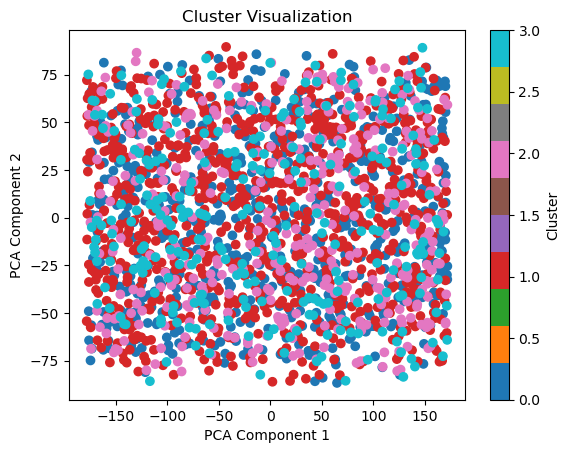

In [4]:
pca = PCA(n_components=2)
cluster_data = [point[0] for cluster in best_clusters for point in cluster]
cluster_labels = [i for i, cluster in enumerate(best_clusters) for _ in cluster]

reduced_data = pca.fit_transform(cluster_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='tab10')
plt.title("Cluster Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [5]:
# Reproduce results by using the found best indexes.
prototypes = best_prototype_index
prototypes = [(num_matrix[i], cat_matrix[i]) for i in prototypes]

clusters, prototypes, prototype_index = k_prototypes_clustering(num_matrix, cat_matrix, k)

print("Reproduced clustering result:")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1}: {len(cluster)} points")


Reproduced clustering result:
Cluster 1: 1149 points
Cluster 2: 419 points
Cluster 3: 200 points
Cluster 4: 381 points


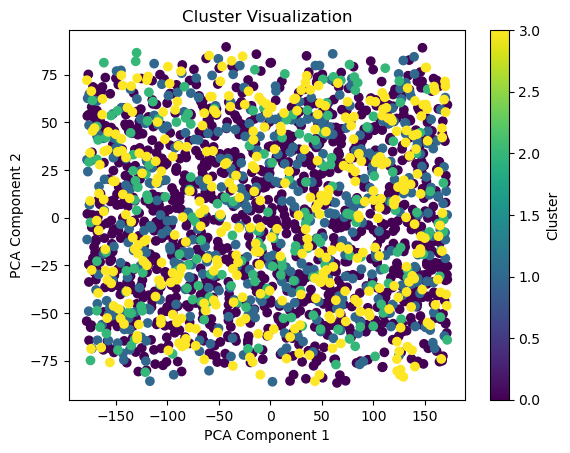

In [6]:
pca = PCA(n_components=2)
cluster_data = [point[0] for cluster in clusters for point in cluster]
cluster_labels = [i for i, cluster in enumerate(clusters) for _ in cluster]

reduced_data = pca.fit_transform(cluster_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels)
plt.title("Cluster Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

Neither of the clustering visualisations show anything that resembles clusters, which can be explained by the fact that the clusters are made up of many more components than just these two. To find if there are any differences, we can try to use the mean and modes of these different components.

In [7]:
means = []
modes = []
ratios = []
for cluster in clusters:
    cluster_num_matrix = np.array([item[0] for item in cluster])
    cluster_cat_matrix = np.array([item[1] for item in cluster])
    diagnosis = cluster_cat_matrix[:, -1]
    count_zeros = np.sum(diagnosis == 0)
    count_ones = np.sum(diagnosis == 1)
    ratios.append(count_ones/(count_zeros + count_ones))
    cluster_means = np.mean(cluster_num_matrix, axis=0)
    cluster_modes = mode(cluster_cat_matrix, axis=0).mode
    means.append(cluster_means)
    modes.append(cluster_modes)


print('-- Ratios of diagnosis --')
print(ratios)

print('-- Numerical Columns means --')
for i in range(len(num_cols)):
    print(num_cols[i])
    print([mean[i] for mean in means])

print('-- Categorical Columns modes --')
for i in range(len(cat_cols)):
    print(cat_cols[i])
    print([mode[i] for mode in modes])


-- Ratios of diagnosis --
[0.3629242819843342, 0.3126491646778043, 0.39, 0.35170603674540685]
-- Numerical Columns means --
BMI
[27.768929150369843, 27.608430751277748, 27.27085754094009, 27.568212778502755]
SystolicBP
[134.30461270670148, 134.381861575179, 135.955, 133.1286089238845]
DiastolicBP
[90.02872062663185, 90.51551312649164, 87.625, 89.73490813648294]
CholesterolTotal
[226.65653869547822, 220.9950257947136, 227.32379056837271, 224.30296899207354]
CholesterolLDL
[122.781757294587, 127.11486307258288, 122.99362489765348, 126.67152793699738]
CholesterolHDL
[60.76849615211543, 57.63614952009748, 56.31970736719491, 59.1880381082175]
CholesterolTriglycerides
[228.0802239855688, 226.65166228305443, 223.9980479729937, 232.92940114609866]
MMSE
[14.688237516629203, 15.416850016474815, 13.783638954060136, 14.739122748050839]
FunctionalAssessment
[5.012898890001219, 5.227927365991427, 5.064301109789415, 5.128229711624515]
AlcoholConsumption
[10.258914183085336, 9.29952922785487, 10.02274

As we can see there are no significant differences between the clusters. Sometimes, the clustering algorithm returns clusters where the diagnoses are spread evenly (about 33% of patients have one per cluster). Even when the algorithm returns clusters where there are some with (close to) 0 diagnoses and others where (close to) everyone has a diagnosis, we still cannot find any differences.